# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import spacy

# **Load Data**

In [ ]:
data = pd.read_csv('/content/Emotion_classify_Data.csv')
data.head(10)

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
5,i feel jealous becasue i wanted that kind of l...,anger
6,when a friend of mine keeps telling me morbid ...,anger
7,i finally fell asleep feeling angry useless an...,anger
8,i feel a bit annoyed and antsy in a good way,anger
9,i feel like i ve regained another vital part o...,joy


In [ ]:
data.shape

(5937, 2)

In [ ]:
data['Emotion'].value_counts()

,count
Emotion,
anger,2000
joy,2000
fear,1937


# **Tokenization, Remove Stop words,  Lemmatization**



In [ ]:
text = data['Comment']

In [ ]:
nlp = spacy.load('en_core_web_sm')
filtered_tokens = []
for sentence in text:
  doc = nlp(sentence)
  # tokens = [token.text for token in doc]
  # filtered_tokens = [token.text for token in doc if not token.is_stop]
  filtered_tokens.append(' '.join([token.lemma_ for token in doc if not token.is_stop])) # lemmatization

In [ ]:
filtered_tokens[0:5]

['seriously hate subject death feel reluctant drop',
 'm life feel appalled',
 'sit write start dig feeling think afraid accept possibility',
 've angry r feel like idiot trust place',
 'feel suspicious outside like rapture happen']

In [ ]:
data['processed_comments'] = filtered_tokens
data.tail()

,Comment,Emotion,processed_comments
5932,i begun to feel distressed for you,fear,begin feel distressed
5933,i left feeling annoyed and angry thinking that...,anger,leave feel annoyed angry thinking center stupi...
5934,i were to ever get married i d have everything...,joy,marry d ready offer ve get club perfect good l...
5935,i feel reluctant in applying there because i w...,fear,feel reluctant apply want able find company kn...
5936,i just wanted to apologize to you because i fe...,anger,want apologize feel like heartless bitch


# **Encoding Emotion Col:** using LabelEncoder



In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Emotion_encoded'] = le.fit_transform(data['Emotion'])
data.head()

,Comment,Emotion,processed_comments,Emotion_encoded
0,i seriously hate one subject to death but now ...,fear,seriously hate subject death feel reluctant drop,1
1,im so full of life i feel appalled,anger,m life feel appalled,0
2,i sit here to write i start to dig out my feel...,fear,sit write start dig feeling think afraid accep...,1
3,ive been really angry with r and i feel like a...,joy,ve angry r feel like idiot trust place,2
4,i feel suspicious if there is no one outside l...,fear,feel suspicious outside like rapture happen,1


# **Split data**

In [ ]:
X = data['processed_comments']
y = data['Emotion_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4749,)
Shape of X_test:  (1188,)


# **Convert text column to numeric vectors using TF-IDF**

In [ ]:
tfidf = TfidfVectorizer()

X_train_v = tfidf.fit_transform(X_train)
X_test_v = tfidf.transform(X_test)
# print(v.vocabulary_)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# **SVM**


In [ ]:
svm_params = {
    "C": [0.01, 0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

In [ ]:
svm = SVC()
svm_grid = GridSearchCV(svm, svm_params, cv=cv, scoring="accuracy")
svm_grid.fit(X_train_v, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [ ]:
print("Best SVM Params:", svm_grid.best_params_)
print("Best SVM Score:", svm_grid.best_score_)

Best SVM Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM Score: 0.9275647495979147


In [ ]:
print("Training Accuracy:", svm_grid.best_estimator_.score(X_train_v, y_train))
print("Test Accuracy:", svm_grid.score(X_test_v, y_test))

Training Accuracy: 0.9865234786270793
Test Accuracy: 0.9292929292929293


# **Logistic Regression**

In [ ]:
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

In [ ]:
lr = LogisticRegression(max_iter=1000, solver='liblinear')

lr_grid = GridSearchCV(lr, param_grid, cv=cv, n_jobs=-1, verbose=2)
lr_grid.fit(X_train_v, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
             verbose=2)

In [ ]:
print("Best Parameters:", lr_grid.best_params_)
print("Best CV Score:", lr_grid.best_score_)

Best Parameters: {'C': 10, 'penalty': 'l1'}
Best CV Score: 0.9401981032665965


In [ ]:
print("Training Accuracy:", lr_grid.best_estimator_.score(X_train_v, y_train))
print("Test Accuracy:", lr_grid.score(X_test_v, y_test))


Training Accuracy: 0.9987365761212887
Test Accuracy: 0.9436026936026936


In [ ]:
y_pred = lr_grid.predict(X_test_v)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       400
           1       0.95      0.92      0.94       388
           2       0.94      0.97      0.95       400

    accuracy                           0.94      1188
   macro avg       0.94      0.94      0.94      1188
weighted avg       0.94      0.94      0.94      1188



# **RandomForest Classifier**

In [ ]:
rf = RandomForestClassifier(random_state=42, n_estimators = 200)

rf.fit(X_train_v, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
y_pred = rf.predict(X_test_v)

In [ ]:
print(classification_report(y_test, y_pred))
print("train_accuracy", rf.score(X_train_v, y_train))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       400
           1       0.93      0.92      0.93       388
           2       0.93      0.95      0.94       400

    accuracy                           0.93      1188
   macro avg       0.93      0.93      0.93      1188
weighted avg       0.93      0.93      0.93      1188

train_accuracy 0.9995788587070963


# **XGBoost Classifier**

In [ ]:
xgb = XGBClassifier(
    n_estimators = 200,
    gamma = 1,
    subsample = 0.8,
    reg_alpha = 0.01,
    reg_lambda = 1,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42)

xgb.fit(X_train_v, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:59:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb.predict(X_test_v)

In [ ]:
train_acc = xgb.score(X_train_v, y_train)
print("Training Accuracy:", train_acc)

print(classification_report(y_test, y_pred))

Training Accuracy: 0.9755738050115814
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       400
           1       0.94      0.94      0.94       388
           2       0.95      0.97      0.96       400

    accuracy                           0.95      1188
   macro avg       0.95      0.95      0.95      1188
weighted avg       0.95      0.95      0.95      1188



In [ ]:
scores = cross_val_score(xgb, X_train_v, y_train, cv=cv, scoring="accuracy")

print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:00:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:00:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:00:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:00:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:00:46] WARNING: /w

Cross-validation scores: [0.95052632 0.92842105 0.92210526 0.93157895 0.92623815]
Mean CV accuracy: 0.9317739448727191


After testing multiple classifiers (SVM, Logistic Regression, Random Forest, XGBoost),  
the **XGBoost Classifier achieved the highest performance** with accuracy = 95%


# **Confusion Matrix for XGBoost Classifier**


<Figure size 800x600 with 0 Axes>

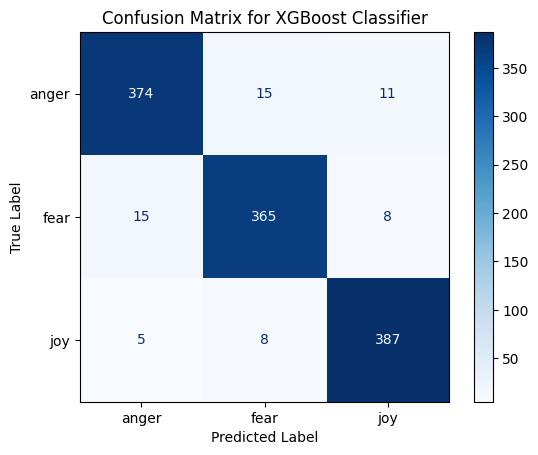

In [ ]:
cm = confusion_matrix(y_test, y_pred)
class_labels = le.classes_

plt.figure(figsize=(8, 6))
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
display_cm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Testing the Model**

In [ ]:
label_map = {0: "angry", 1: "fear", 2: "joy"}

In [ ]:
new_text = ["Walking down that dark street makes me nervous."]

new_text_v = tfidf.transform(new_text)
pred = xgb.predict(new_text_v)[0]
print(label_map[pred])

fear


In [ ]:
i = 5
pred = xgb.predict(X_test_v[i].reshape(1, -1))[0]

print(pred,"-->", label_map[pred],"-->",  X_test.iloc[i])
print()

0 --> angry --> carry grudge long time feel wrong hurt someway aware

